In [1]:
import xarray as xr
import numpy as np
import cmocean as cm
import os
import pandas as pd
from matplotlib import cm as cmap
%matplotlib inline

In [2]:
from dask.distributed import Client

In [3]:
c=Client()
c

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42243 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42243/status,
Dashboard: /proxy/42243/status,Workers: 6
Total threads: 24,Total memory: 96.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33615,Workers: 6
Dashboard: /proxy/42243/status,Total threads: 24
Started: Just now,Total memory: 96.00 GiB
Comm: tcp://127.0.0.1:32795,Total threads: 4
Dashboard: /proxy/42827/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34181,


In [4]:
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import matplotlib.ticker as mticker
import cmocean as cm

In [5]:
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='#DFD1AF',
                                        linewidth=0.2)

# Load data

In [6]:
path='/g/data/rr7/JRA55/6hr/atmos/'

In [7]:
u_10_p='uas/v1/uas_*.nc'
v_10_p='vas/v1/vas_*.nc'

In [8]:
u_10=xr.open_mfdataset(path+u_10_p,combine='nested',concat_dim='time',chunks={'time':199,'lon':160,'lat':100},parallel=True)
v_10=xr.open_mfdataset(path+v_10_p,combine='nested',concat_dim='time',chunks={'time':199,'lon':160,'lat':100},parallel=True)

In [12]:
eddy_climat = xr.open_mfdataset('../datasets/daily/eddy_stats_timeseries_*.nc', chunks={'time':1000,'lon':10,'lat':10})

In [13]:
eddy_climat

,Array,Chunk
Bytes,3.77 GiB,285.94 kiB
Shape,"(10016, 140, 361)","(366, 10, 10)"
Count,29036 Tasks,14504 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,3.77 GiB,285.94 kiB
Shape,"(10016, 140, 361)","(366, 10, 10)"
Count,29036 Tasks,14504 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


### Grid and remove running averages

#### Winds

In [14]:
wind_mag = np.sqrt(u_10.uas**2 + v_10.vas**2)

In [15]:
wind_mag = wind_mag.chunk({'time':100})

In [16]:
wind_mag_dayly = wind_mag.sel(time=slice(eddy_climat.time[0],eddy_climat.time[-1])).resample(time='1D').mean()#.transpose('lat','lon','time')

In [17]:
wind_mag_dayly = wind_mag_dayly.chunk({'time':199})

In [18]:
wind_mag_rolling_12m = wind_mag_dayly.rolling(time=365, center=True).mean(skipna=True)

In [19]:
wind_mag_dayly_minus_lttrends = (wind_mag_dayly - wind_mag_rolling_12m).chunk({'time':199})

In [20]:
wind_mag_rolled = wind_mag_dayly_minus_lttrends.rolling(time = 30*6).construct("new1").mean("new1", skipna=True)

#### Eddy properties

In [21]:
eddy_climat = eddy_climat.sel(time=slice(wind_mag_dayly.time[0],wind_mag_dayly.time[-1])).chunk({'time':1000})

In [22]:
eddy_climat_rolling_12m = eddy_climat.rolling(time = 365).construct("new").mean("new", skipna=True)

In [23]:
eddy_climat_minus_lttrends = eddy_climat - eddy_climat_rolling_12m


In [24]:
eddy_climat = eddy_climat_minus_lttrends.rolling(time = 30*6).construct("new1").mean("new1", skipna=True)

In [25]:
eddy_climat_ts = eddy_climat.isel({'lon':slice(0,360)}).coarsen({'lat':4,'lon':4}).mean()
eddy_climat_ts['eddy_n'] = eddy_climat['eddy_n'].isel({'lon':slice(0,360)}).coarsen({'lat':4,'lon':4}).sum()

In [26]:
eddy_climat_compare = eddy_climat_ts

# Compute correlations

In [27]:
from correlation import correlation

In [30]:
wind_mag_compare = xr.open_dataset('../datasets/wind_mag_gridded_4_correlation.nc')
eddy_climat_compare_data = xr.open_dataset('../datasets/eddy_climat_gridded_4_correlation.nc')

In [31]:
wind_mag_compare= wind_mag_compare.rolling(time = 90,center=True).mean()
eddy_climat_compare_data= eddy_climat_compare_data.rolling(time = 90,center=True).mean()

Correlation with all data

In [32]:
wind_mag_compare = wind_mag_compare
eddy_climat_compare = eddy_climat_compare_data

Correlation only within an average seasonal cycle

In [33]:
wind_mag_compare = wind_mag_compare.groupby(wind_mag_compare['time.dayofyear']).mean().isel(dayofyear=slice(0,365))
eddy_climat_compare = eddy_climat_compare_data.groupby(eddy_climat_compare_data['time.dayofyear']).mean().isel(dayofyear=slice(0,365))
eddy_climat_compare['eddy_n'] = eddy_climat_compare_data.eddy_n.groupby(eddy_climat_compare_data['time.dayofyear']).sum().isel(dayofyear=slice(0,365))

In [36]:
# plt.figure(figsize=(10,3))
y = (eddy_climat_compare.eddy_n.sel({'lon':150,'lat':30},method='nearest'))#.plot(color='k')
# plt.figure(figsize=(10,3))
y2 = wind_mag_compare.__xarray_dataarray_variable__.sel({'lon':150,'lat':30},method='nearest')#.plot()

In [38]:
c = correlation.Compute_Correlation(y2,y,nc=365)

In [39]:
method = 'Cyclic'
# method = 'Trim'
nc=365

In [40]:
xcorr = correlation.xarrayCompute_Correlation(wind_mag_compare.__xarray_dataarray_variable__,eddy_climat_compare.eddy_n,axis=0,nc=nc,method=method)

In [41]:
corr_values = xcorr._calc_correlation_along_axis(chunks={'lat':10,'lon':10})

/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:30: RuntimeWarning: Mean of empty slice
  self.y2t = y2 - np.nanmean(y2)
/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:56: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(x1t*x2t)/np.sqrt(np.nanmean(x1t**2)*np.nanmean(x2t**2))


In [42]:
corr_results_n = corr_values.compute()

/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:56: RuntimeWarning: invalid value encountered in double_scalars
  corr = np.nanmean(x1t*x2t)/np.sqrt(np.nanmean(x1t**2)*np.nanmean(x2t**2))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:56: RuntimeWarning: invalid value encountered in double_scalars
  corr = np.nanmean(x1t*x2t)/np.sqrt(np.nanmean(x1t**2)*np.nanmean(x2t**2))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/dat

In [43]:
# corr_results[0].shape

In [44]:
xcorr = correlation.xarrayCompute_Correlation(wind_mag_compare.__xarray_dataarray_variable__,eddy_climat_compare.eddy_a,axis=0,nc=nc,method=method)

In [45]:
corr_values = xcorr._calc_correlation_along_axis(chunks={'lat':10,'lon':10})

/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:30: RuntimeWarning: Mean of empty slice
  self.y2t = y2 - np.nanmean(y2)
/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:56: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(x1t*x2t)/np.sqrt(np.nanmean(x1t**2)*np.nanmean(x2t**2))


In [46]:
corr_results_amp = corr_values.compute()

/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:30: RuntimeWarning: Mean of empty slice
  self.y2t = y2 - np.nanmean(y2)
/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:56: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(x1t*x2t)/np.sqrt(np.nanmean(x1t**2)*np.nanmean(x2t**2))
/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:30: RuntimeWarning: Mean of empty slice
  self.y2t = y2 - np.nanmean(y2)
/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:56: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(x1t*x2t)/np.sqrt(np.nanmean(x1t**2)*np.nanmean(x2t**2))
/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:30: RuntimeWarning: Mean of empty slice
  self.y2t = y2 - np.nanmean(y2)
/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.

In [47]:
amp = (eddy_climat_compare.eddy_a_p-eddy_climat_compare.eddy_a_n)

In [48]:
xcorr = correlation.xarrayCompute_Correlation(wind_mag_compare.__xarray_dataarray_variable__,amp,axis=0,nc=nc,method=method)

In [49]:
corr_values = xcorr._calc_correlation_along_axis(chunks={'lat':10,'lon':10})

/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:30: RuntimeWarning: Mean of empty slice
  self.y2t = y2 - np.nanmean(y2)
/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures/correlation/correlation.py:56: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(x1t*x2t)/np.sqrt(np.nanmean(x1t**2)*np.nanmean(x2t**2))


In [50]:
corr_results_abs_amp = corr_values.compute()

# PLOT

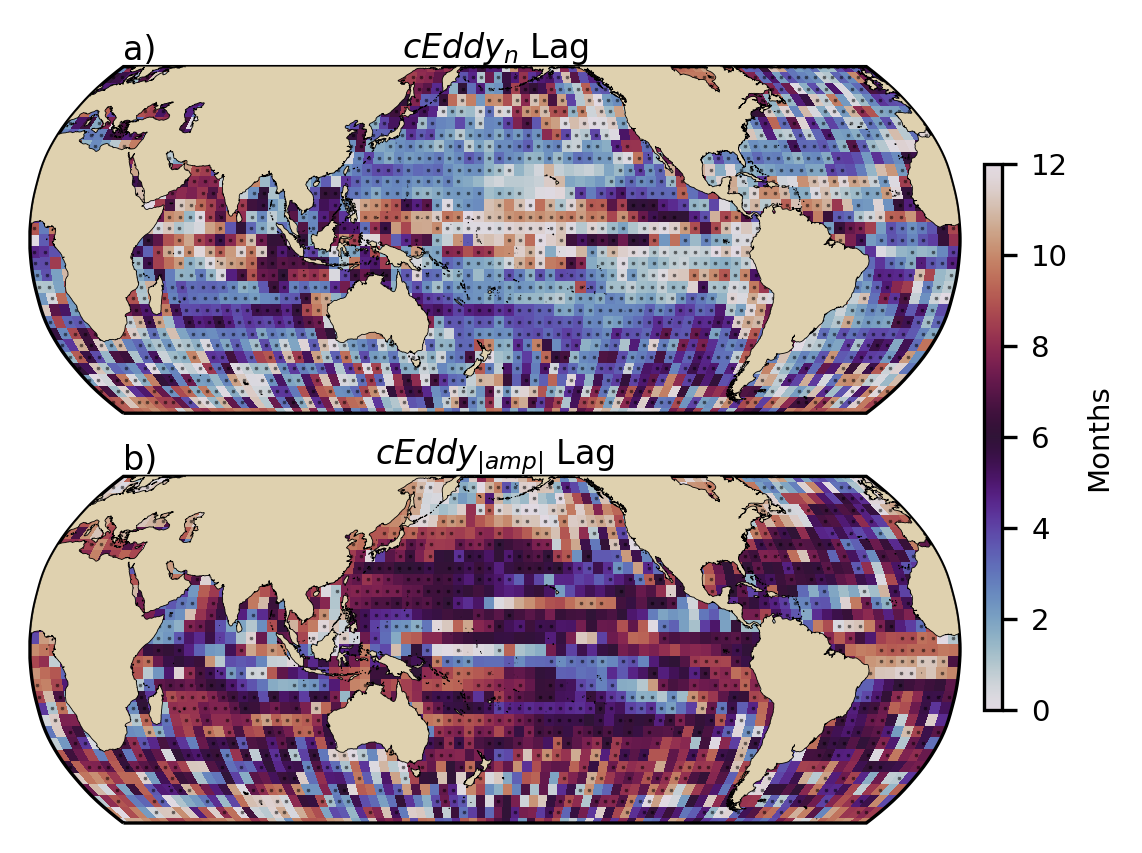

In [56]:
cmap = 'rainbow'

cbar_kwargs=dict(pad=0.15, shrink=1, label=r'')

fig, (ax) = plt.subplots(2, 1, figsize=(4, 3.5),dpi=300, 
                                    subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

######################################################################
######################################################################

clm = ax[0].pcolormesh(eddy_climat_compare.lon,eddy_climat_compare.lat,
               corr_results_n[0].argmax(axis=0)/31,transform =ccrs.PlateCarree(),
                       cmap="twilight",vmin=0,vmax=12)

ax[0].set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax[0].add_feature(land_50m,zorder=10)
ax[0].set_title(r'$cEddy_{n}$ Lag', fontsize=8, pad=2)

arg_max = corr_results_n[0].argmax(axis=0) 
signif = np.take_along_axis(corr_results_n[-2], corr_results_n[0].argmax(axis=0)[np.newaxis,:,:],axis=0)
signif_ravel=np.squeeze(signif).ravel()
signif_ravel[~np.isfinite(signif_ravel)]=0
signif_bool = np.array(signif_ravel,dtype=bool)
X,Y = np.meshgrid(eddy_climat_compare.lon,eddy_climat_compare.lat)

x = X.ravel()[signif_bool]#+0.5
y = Y.ravel()[signif_bool]#+0.5

ax[0].plot(x,y,marker='*',linestyle='',color='k',alpha=0.5,transform =ccrs.PlateCarree(),markersize=0.3)
######################################################################
######################################################################
clm = ax[1].pcolormesh(eddy_climat_compare.lon,eddy_climat_compare.lat,
               corr_results_abs_amp[0].argmax(axis=0)/31,transform =ccrs.PlateCarree(),
                       cmap="twilight",vmin=0,vmax=12)

ax[1].set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax[1].add_feature(land_50m,zorder=10)
ax[1].set_title(r'$cEddy_{|amp|}$ Lag', fontsize=8, pad=2)

arg_max = corr_results_abs_amp[0].argmax(axis=0) 
signif = np.take_along_axis(corr_results_abs_amp[-2], corr_results_abs_amp[0].argmax(axis=0)[np.newaxis,:,:],axis=0)
signif_ravel=np.squeeze(signif).ravel()
signif_ravel[~np.isfinite(signif_ravel)]=0
signif_bool = np.array(signif_ravel,dtype=bool)
X,Y = np.meshgrid(eddy_climat_compare.lon,eddy_climat_compare.lat)

x = X.ravel()[signif_bool]#+0.5
y = Y.ravel()[signif_bool]#+0.5

ax[1].plot(x,y,marker='*',linestyle='',color='k',alpha=0.5,transform =ccrs.PlateCarree(),markersize=0.3)
######################################################################
######################################################################

cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.52])
cbar=fig.colorbar(clm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Months', rotation=90, fontsize=7)
cbar.ax.tick_params(labelsize=7) 

ax[0].text(0.1,1.02,r'a)',fontsize=8,transform=ax[0].transAxes)
ax[1].text(0.1,1.02,r'b)',fontsize=8,transform=ax[1].transAxes)

plt.subplots_adjust(wspace=0.05, hspace=0.07)
plt.savefig('Figure_9_correlation_lag_eddy_properties.pdf',dpi=300,bbox_inches='tight')